In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from sklearn.model_selection import train_test_split
from sklearn import set_config

from sklearn.pipeline import make_pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_validate, GridSearchCV

In [2]:
firm_performance = pd.read_csv('../Input_data_clean/Firm_Performance.csv')
firm_data = pd.read_csv('../input_data/Firm_data.csv')

In [3]:
firm_performance

,tic,fyear,roa,EBITDA_margin,NI_rev,roe,eps,chng_price,div_yield,vol,mva,tobinsQ,asset_g,revenue_g,ni_g,employee_g
0,AAL,2010,-0.018774,0.058773,-0.021245,0.119392,-1.412506,1.123690,0.000000,0.604973,6542.5755,1.260785,-0.013759,0.113119,-0.679155,-0.008238
1,AAL,2011,-0.082984,0.028932,-0.082383,0.278301,-5.902740,-0.523944,0.000000,0.642134,7228.3438,1.303101,-0.049426,0.083536,3.201699,0.023642
2,AAL,2012,-0.079796,0.057695,-0.075478,0.234882,-5.595123,1.498047,0.000000,0.572826,8253.5571,1.351066,-0.014173,0.034677,-0.052046,-0.029338
3,AAL,2013,-0.043380,0.110662,-0.068658,0.671549,-7.024963,0.772532,0.000000,0.362859,9322.9923,1.220516,0.798299,0.074713,-0.022388,0.419936
4,AAL,2014,0.065843,0.154396,0.067573,1.426027,4.132048,1.117107,0.003729,0.386805,35384.5843,1.808402,0.035314,0.596661,-2.571429,0.026268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4877,ALLE,2015,0.067343,0.214738,0.074416,6.011719,1.603275,0.217927,0.006068,0.203976,6302.1267,3.757680,0.133638,-0.023698,-0.121575,0.105882
4878,ALLE,2016,0.101940,0.218945,0.102368,2.022065,2.404643,-0.000967,0.007500,0.221979,5984.2360,3.662737,-0.016584,0.082153,0.488629,0.000000
4879,ALLE,2017,0.107514,0.235570,0.113487,0.680528,2.874966,0.239666,0.008044,0.173708,7161.5327,3.817283,0.131085,0.076050,0.192929,0.063830
4880,ALLE,2018,0.154758,0.226599,0.159205,0.668049,4.595454,-0.007339,0.010538,0.227619,6892.5153,3.452678,0.105507,0.134333,0.591292,0.100000


In [4]:
set_config(display="diagram")

performance_score = firm_performance
firm_performance = firm_performance.dropna(subset=['tobinsQ'])
# load data and split off X and y
y = firm_performance.tobinsQ
firm_performance = firm_performance.drop('tobinsQ',axis=1)

scores_df = firm_performance[['tic', 'fyear']].copy()

firm_performance = firm_performance.drop('fyear',axis=1)

In [5]:
# create test set for use later
rng = np.random.RandomState(0)
X_train, X_test, y_train, y_test = train_test_split(firm_performance, y, random_state=rng)

In [6]:
numer_pipe = make_pipeline(SimpleImputer(), 
                           StandardScaler())

preproc_pipe = ColumnTransformer(
    [ 
    # numerical vars
    ("num_impute", numer_pipe, make_column_selector(dtype_include=np.number)),
    ]
    , remainder = 'drop'
)

In [7]:
preproc_pipe

ColumnTransformer(transformers=[('num_impute',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fecc6e514f0>)])

In [8]:
linear_pipe = make_pipeline(preproc_pipe,
                           LinearRegression())

results = linear_pipe.fit(X_train, y_train)

In [9]:
y_test_predict = linear_pipe.predict(X_test)
test_score = r2_score(y_test,y_test_predict)
test_score

0.34946386410505037

In [10]:
coefficients = linear_pipe.named_steps['linearregression'].coef_
coefficients

array([ 0.88051004,  0.01140522, -0.41031816, -0.06891314, -0.13385857,
        0.30880129, -0.2087156 ,  0.20311097,  0.1833395 , -0.0452349 ,
        0.11832085,  0.01631271,  0.17517143])

In [11]:
coef_df = pd.DataFrame({'metric':X_train.columns[1:],
                        'weight':coefficients})
coef_df

,metric,weight
0,roa,0.880510
1,EBITDA_margin,0.011405
2,NI_rev,-0.410318
3,roe,-0.068913
4,eps,-0.133859
5,chng_price,0.308801
6,div_yield,-0.208716
7,vol,0.203111
8,mva,0.183339
9,asset_g,-0.045235


In [12]:
weights = np.abs(coefficients) / np.sum(np.abs(coefficients))

In [13]:
weight_df = pd.DataFrame({'metric':X_train.columns[1:],
                        'weight':weights})
weight_df

,metric,weight
0,roa,0.318562
1,EBITDA_margin,0.004126
2,NI_rev,0.148450
3,roe,0.024932
4,eps,0.048429
5,chng_price,0.111722
6,div_yield,0.075512
7,vol,0.073484
8,mva,0.066331
9,asset_g,0.016366


In [14]:
weight_dict = weight_df.set_index('metric').T.to_dict('list')

In [15]:
scaler = StandardScaler()
performance_score = pd.DataFrame(scaler.fit_transform(performance_score.iloc[:, 2:]), columns=performance_score.iloc[:, 2:].columns)

In [16]:
performance_score

,roa,EBITDA_margin,NI_rev,roe,eps,chng_price,div_yield,vol,mva,tobinsQ,asset_g,revenue_g,ni_g,employee_g
0,-1.064598,-0.779009,-0.588044,0.002450,-0.003444,3.047495,-0.655657,3.439295,-0.319913,-0.606562,-0.372228,0.054612,-0.069031,-0.369472
1,-1.900607,-0.909013,-0.870503,0.058396,-0.003869,-2.309564,-0.655657,3.808737,-0.307645,-0.582438,-0.472503,-0.032340,0.318936,-0.195798
2,-1.859098,-0.783708,-0.838602,0.043110,-0.003840,4.264665,-0.655657,3.119697,-0.289305,-0.555093,-0.373393,-0.175950,-0.006339,-0.484418
3,-1.384961,-0.552956,-0.807096,0.196843,-0.003976,1.905753,-0.655657,1.032283,-0.270173,-0.629519,1.910785,-0.058273,-0.003374,1.963075
4,0.037104,-0.362427,-0.177700,0.462465,-0.002919,3.026090,-0.523556,1.270344,0.196055,-0.294367,-0.234265,1.475852,-0.258201,-0.181493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4877,0.056644,-0.099547,-0.146086,2.076907,-0.003158,0.102528,-0.440713,-0.547280,-0.324215,0.816907,0.042161,-0.347527,-0.013290,0.252218
4878,0.507089,-0.081218,-0.016946,0.672307,-0.003082,-0.609176,-0.389986,-0.368303,-0.329902,0.762780,-0.380172,-0.036407,0.047712,-0.324593
4879,0.579659,-0.008793,0.034424,0.200004,-0.003038,0.173210,-0.370708,-0.848195,-0.308841,0.850886,0.034984,-0.054344,0.018151,0.023130
4880,1.194771,-0.047876,0.245642,0.195611,-0.002875,-0.629895,-0.282365,-0.312233,-0.313653,0.643026,-0.036924,0.116962,0.057975,0.220173


In [17]:
for metric in weight_dict:
    performance_score[metric] = performance_score[metric] * weight_dict[metric]

In [18]:
performance_score['Performance Score'] = performance_score.sum(axis=1)

In [19]:
performance_score

,roa,EBITDA_margin,NI_rev,roe,eps,chng_price,div_yield,vol,mva,tobinsQ,asset_g,revenue_g,ni_g,employee_g,Performance Score
0,-0.339141,-0.003214,-0.087295,0.000061,-0.000167,0.340473,-0.049510,0.252734,-0.021220,-0.606562,-0.006092,0.002338,-0.000407,-0.023416,-0.541419
1,-0.605462,-0.003751,-0.129226,0.001456,-0.000187,-0.258029,-0.049510,0.279882,-0.020406,-0.582438,-0.007733,-0.001384,0.001882,-0.012409,-1.387316
2,-0.592239,-0.003234,-0.124491,0.001075,-0.000186,0.476457,-0.049510,0.229248,-0.019190,-0.555093,-0.006111,-0.007532,-0.000037,-0.030700,-0.681542
3,-0.441196,-0.002282,-0.119813,0.004908,-0.000193,0.212915,-0.049510,0.075856,-0.017921,-0.629519,0.031271,-0.002495,-0.000020,0.124411,-0.813586
4,0.011820,-0.001495,-0.026380,0.011530,-0.000141,0.338081,-0.039535,0.093350,0.013005,-0.294367,-0.003834,0.063178,-0.001524,-0.011502,0.152185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4877,0.018045,-0.000411,-0.021686,0.051782,-0.000153,0.011455,-0.033279,-0.040216,-0.021505,0.816907,0.000690,-0.014877,-0.000078,0.015985,0.782657
4878,0.161539,-0.000335,-0.002516,0.016762,-0.000149,-0.068058,-0.029449,-0.027064,-0.021883,0.762780,-0.006222,-0.001558,0.000282,-0.020571,0.763558
4879,0.184657,-0.000036,0.005110,0.004987,-0.000147,0.019351,-0.027993,-0.062329,-0.020486,0.850886,0.000573,-0.002326,0.000107,0.001466,0.953820
4880,0.380609,-0.000198,0.036466,0.004877,-0.000139,-0.070373,-0.021322,-0.022944,-0.020805,0.643026,-0.000604,0.005007,0.000342,0.013954,0.947895


In [20]:
scores_df['Performance_Score'] = performance_score['Performance Score']

In [21]:
scores_df.drop_duplicates()
scores_df.describe()

,fyear,Performance_Score
count,4772.000000,4772.000000
mean,2014.512364,0.003889
std,2.888781,1.249185
min,2009.000000,-8.641338
25%,2012.000000,-0.762202
50%,2015.000000,-0.336501
75%,2017.000000,0.372112
max,2019.000000,11.411897


In [22]:
scores_df.query('Performance_Score >= 11')

,tic,fyear,Performance_Score
4485,DXCM,2014,11.411897


In [23]:
small_bod_df = pd.read_csv('../Saved/small_bod_df.csv')
small_ceo_df = pd.read_csv('../Saved/small_ceo_df.csv')
med_bod_df = pd.read_csv('../Saved/medium_bod_df.csv')
med_ceo_df = pd.read_csv('../Saved/medium_ceo_df.csv')
large_bod_df = pd.read_csv('../Saved/large_bod_df.csv')
large_ceo_df = pd.read_csv('../Saved/large_ceo_df.csv')

pred_small_bod_df = pd.read_csv('../Saved/pred_small_bod_df.csv')
pred_small_ceo_df = pd.read_csv('../Saved/pred_small_ceo_df.csv')
pred_med_bod_df = pd.read_csv('../Saved/pred_med_bod_df.csv')
pred_med_ceo_df = pd.read_csv('../Saved/pred_med_ceo_df.csv')
pred_large_bod_df = pd.read_csv('../Saved/pred_large_bod_df.csv')
pred_large_ceo_df = pd.read_csv('../Saved/pred_large_ceo_df.csv')

In [24]:
small_bod_df

,signature_index,total_director_comp
0,847603370a479bc2ed0bb3a74b270aae,2004.756
1,55321521b6e50b4bccfe97ebffed402d,2004.756
2,6602b77c9233d608bee1e0ef777ceabe,2844.516
3,a4a364c43e04b6e306a019531f0c989c,916.408
4,72c81d3d7e18ddc6f0d59d44f315d924,916.408
...,...,...
350,4ba265aceebf418304d95acc6bf7ee46,370.362
351,34f17cbdc11567bffaaba85e4aa30d7a,0.000
352,58005ef83812589ce047027b2a097766,0.000
353,b33c9610b47875a2cebb9d47b97dd758,200.136


In [25]:
small_bod_df['prediction'] = pred_small_bod_df['prediction']
med_bod_df['prediction'] = pred_med_bod_df['prediction']
large_bod_df['prediction'] = pred_large_bod_df['prediction']

small_ceo_df['prediction'] = pred_small_ceo_df['prediction']
med_ceo_df['prediction'] = pred_med_ceo_df['prediction']
large_ceo_df['prediction'] = pred_large_ceo_df['prediction']

In [26]:
small_ceo_df

,signature_index,tdc1,prediction
0,541a33f0a267ea6ff5bdf1ddbae46d42,8161.669,8465.221989
1,6d9a159cc6f08f58e0b9e1c1c4a7cc23,9935.099,8510.467080
2,62e209384e3f3e733406a530cd31d3ae,10894.820,21038.487437
3,d9a478f9d4186aea3a643451c3be14de,5238.064,6853.916161
4,9ad7fc47ab6064d852bfc28f4ea99293,4374.845,6001.840782
...,...,...,...
2885,7d1d67a047b29e87c83818609f9c4049,3886.852,4263.088036
2886,d3113a11e175f60ea9e6773e1b490572,3084.224,2331.497829
2887,50774b063a7cce98a7b1a33170059ed5,3786.788,2502.518717
2888,e82fccc208aacc0aeb70c4253640e232,6530.474,4761.113946


In [27]:
small_bod_df['over_under_comp'] = small_bod_df['total_director_comp']/pred_small_bod_df['prediction']
med_bod_df['over_under_comp'] = med_bod_df['total_director_comp']/pred_med_bod_df['prediction']
large_bod_df['over_under_comp'] = large_bod_df['total_director_comp']/pred_large_bod_df['prediction']

small_bod_df = small_bod_df.drop_duplicates()
med_bod_df = med_bod_df.drop_duplicates()
large_bod_df = large_bod_df.drop_duplicates()

small_ceo_df['over_under_comp'] = small_ceo_df['tdc1']/pred_small_ceo_df['prediction']
med_ceo_df['over_under_comp'] = med_ceo_df['tdc1']/pred_med_ceo_df['prediction']
large_ceo_df['over_under_comp'] = large_ceo_df['tdc1']/pred_large_ceo_df['prediction']

small_ceo_df = small_ceo_df.drop_duplicates()
med_ceo_df = med_ceo_df.drop_duplicates()
large_ceo_df = large_ceo_df.drop_duplicates()

In [28]:
BOD_df = pd.read_csv('../input_data_clean/BOD_DF.csv')
CEO_df = pd.read_csv('../input_data_clean/CEO_DF.csv')

In [29]:
BOD_key = BOD_df[['ticker','year','signature_index']]
CEO_key = CEO_df[['ticker','year','signature_index']]

BOD_key = BOD_key.drop_duplicates()
CEO_key = CEO_key.drop_duplicates()

In [30]:
small_bod_df

,signature_index,total_director_comp,prediction,over_under_comp
0,847603370a479bc2ed0bb3a74b270aae,2004.756,2163.453215,0.926646
1,55321521b6e50b4bccfe97ebffed402d,2004.756,2133.387226,0.939706
2,6602b77c9233d608bee1e0ef777ceabe,2844.516,1558.222523,1.825488
3,a4a364c43e04b6e306a019531f0c989c,916.408,1228.554592,0.745924
4,72c81d3d7e18ddc6f0d59d44f315d924,916.408,1057.196842,0.866828
...,...,...,...,...
350,4ba265aceebf418304d95acc6bf7ee46,370.362,301.546028,1.228211
351,34f17cbdc11567bffaaba85e4aa30d7a,0.000,438.642288,0.000000
352,58005ef83812589ce047027b2a097766,0.000,495.517213,0.000000
353,b33c9610b47875a2cebb9d47b97dd758,200.136,738.002764,0.271186


In [31]:
BOD_small_merged = small_bod_df.merge(BOD_key, 
                how='left',
                on='signature_index',
                indicator=False,
                validate='1:1')
BOD_med_merged = med_bod_df.merge(BOD_key, 
                how='left',
                on='signature_index',
                indicator=False,
                validate='1:1')
BOD_large_merged = large_bod_df.merge(BOD_key, 
                how='left',
                on='signature_index',
                indicator=False,
                validate='1:1')

CEO_small_merged = small_ceo_df.merge(CEO_key, 
                how='left',
                on='signature_index',
                indicator=False,
                validate='m:1')
CEO_med_merged = med_ceo_df.merge(CEO_key, 
                how='left',
                on='signature_index',
                indicator=False,
                validate='m:1')
CEO_large_merged = large_ceo_df.merge(CEO_key, 
                how='left',
                on='signature_index',
                indicator=False,
                validate='m:1')

In [32]:
BOD_small = BOD_small_merged[['ticker', 'year', 'over_under_comp']]
BOD_small = BOD_small.rename(columns={'ticker':'tic','year':'fyear'})
BOD_small = BOD_small.merge(scores_df,
                how='left',
                on=['tic','fyear'],
                indicator=False,
                validate='m:1')

BOD_med = BOD_med_merged[['ticker', 'year', 'over_under_comp']]
BOD_med = BOD_med.rename(columns={'ticker':'tic','year':'fyear'})
BOD_med = BOD_med.merge(scores_df,
                how='left',
                on=['tic','fyear'],
                indicator=False,
                validate='m:1')

BOD_large = BOD_large_merged[['ticker', 'year', 'over_under_comp']]
BOD_large = BOD_large.rename(columns={'ticker':'tic','year':'fyear'})
BOD_large = BOD_large.merge(scores_df,
                how='left',
                on=['tic','fyear'],
                indicator=False,
                validate='m:1')

BOD_small = BOD_small.drop_duplicates()
BOD_med = BOD_med.drop_duplicates()
BOD_large = BOD_large.drop_duplicates()

In [33]:
CEO_small = CEO_small_merged[['ticker', 'year', 'over_under_comp']]
CEO_small = CEO_small.rename(columns={'ticker':'tic','year':'fyear'})
CEO_small = CEO_small.merge(scores_df,
                how='left',
                on=['tic','fyear'],
                indicator=False,
                validate='m:1')

CEO_med = CEO_med_merged[['ticker', 'year', 'over_under_comp']]
CEO_med = CEO_med.rename(columns={'ticker':'tic','year':'fyear'})
CEO_med = CEO_med.merge(scores_df,
                how='left',
                on=['tic','fyear'],
                indicator=False,
                validate='m:1')

CEO_large = CEO_large_merged[['ticker', 'year', 'over_under_comp']]
CEO_large = CEO_large.rename(columns={'ticker':'tic','year':'fyear'})
CEO_large = CEO_large.merge(scores_df,
                how='left',
                on=['tic','fyear'],
                indicator=False,
                validate='m:1')

CEO_small = CEO_small.drop_duplicates()
CEO_med = CEO_med.drop_duplicates()
CEO_large = CEO_large.drop_duplicates()

In [34]:
BOD_small_corr = BOD_small['over_under_comp'].corr(BOD_small['Performance_Score'])
BOD_med_corr = BOD_med['over_under_comp'].corr(BOD_med['Performance_Score'])
BOD_large_corr = BOD_large['over_under_comp'].corr(BOD_large['Performance_Score'])

BOD_correlations = pd.DataFrame({'Firm Size':['Small', 'Medium', 'Large'],
                        'Correlation':[BOD_small_corr, BOD_med_corr, BOD_large_corr]})

print('Correlation between BOD payment and firm performance:\n')
print(BOD_correlations)

Correlation between BOD payment and firm performance:

  Firm Size  Correlation
0     Small    -0.116239
1    Medium    -0.026329
2     Large     0.131093


In [35]:
CEO_small_corr = CEO_small['over_under_comp'].corr(CEO_small['Performance_Score'])
CEO_med_corr = CEO_med['over_under_comp'].corr(CEO_med['Performance_Score'])
CEO_large_corr = CEO_large['over_under_comp'].corr(CEO_large['Performance_Score'])

CEO_correlations = pd.DataFrame({'Firm Size':['Small', 'Medium', 'Large'],
                        'Correlation':[CEO_small_corr, CEO_med_corr, CEO_large_corr]})

print('Correlation between CEO payment and firm performance:\n')
print(CEO_correlations)

Correlation between CEO payment and firm performance:

  Firm Size  Correlation
0     Small     0.225228
1    Medium     0.005446
2     Large    -0.226134


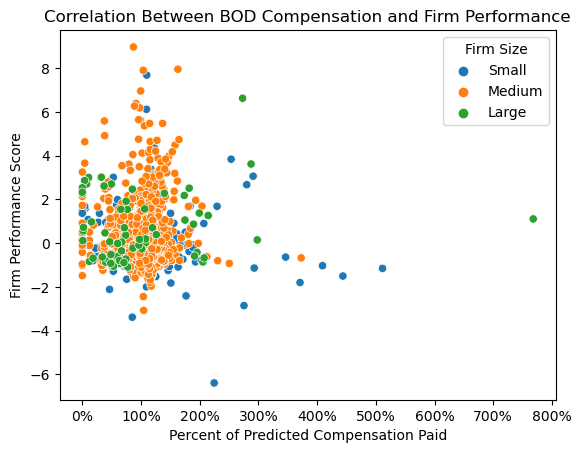

In [36]:
BOD_small['Firm Size'] = 'Small'
BOD_med['Firm Size'] = 'Medium'
BOD_large['Firm Size'] = 'Large'
BOD_combined = pd.concat([BOD_small, BOD_med, BOD_large], axis=0)

fig, ax = plt.subplots()
sns.scatterplot(data=BOD_combined,
                x='over_under_comp',
                y='Performance_Score',
                hue='Firm Size',
                ax=ax)
ax.set(title='Correlation Between BOD Compensation and Firm Performance',
    xlabel='Percent of Predicted Compensation Paid',
    ylabel='Firm Performance Score'
)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
# plt.savefig('images/BOD_corr.png')

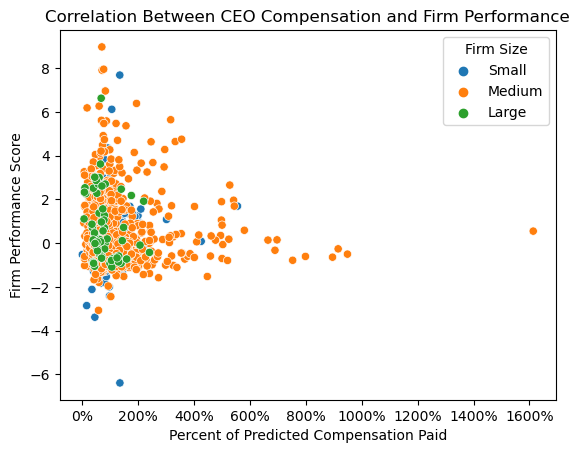

In [37]:
CEO_small['Firm Size'] = 'Small'
CEO_med['Firm Size'] = 'Medium'
CEO_large['Firm Size'] = 'Large'
CEO_combined = pd.concat([CEO_small, CEO_med, CEO_large], axis=0)

fig, ax = plt.subplots()
sns.scatterplot(data = CEO_combined,
            x='over_under_comp',
            y='Performance_Score',
            hue='Firm Size',
            ax=ax)

ax.set(title='Correlation Between CEO Compensation and Firm Performance',
        xlabel = 'Percent of Predicted Compensation Paid',
        ylabel = 'Firm Performance Score')

ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
# plt.savefig('images/CEO_corr.png')

In [38]:
BOD_small.drop_duplicates()

,tic,fyear,over_under_comp,Performance_Score,Firm Size
0,PNW,2017,0.926646,-0.870027,Small
1,PNW,2018,0.939706,-0.855624,Small
2,AMD,2017,1.825488,0.555430,Small
3,ALK,2017,0.745924,-0.373952,Small
4,ALK,2018,0.866828,-0.816051,Small
...,...,...,...,...,...
224,ENPH,2019,1.228211,4.349720,Small
225,EPAM,2017,0.000000,1.478710,Small
226,EPAM,2018,0.000000,1.368606,Small
227,ALLE,2017,0.271186,0.953820,Small


In [39]:
CEO_small.drop_duplicates()

,tic,fyear,over_under_comp,Performance_Score,Firm Size
0,PNW,2017,0.964141,-0.870027,Small
1,PNW,2018,1.167398,-0.855624,Small
2,AMD,2017,0.517852,0.555430,Small
3,ALK,2017,0.764244,-0.373952,Small
4,ALK,2018,0.728917,-0.816051,Small
...,...,...,...,...,...
231,ENPH,2019,0.911746,4.349720,Small
232,EPAM,2017,1.322851,1.478710,Small
233,EPAM,2018,1.513191,1.368606,Small
234,ALLE,2017,1.371627,0.953820,Small


In [40]:
BOD_small = BOD_small.rename(columns={'over_under_comp':'over_under_bod'})
CEO_small = CEO_small.rename(columns={'over_under_comp':'over_under_ceo'})

small_bod_ceo = pd.merge(BOD_small, CEO_small, 
                         on=['tic','fyear'],
                         how='left',
                         validate='1:m')
small_bod_ceo = small_bod_ceo[['tic','fyear','over_under_ceo','over_under_bod','Performance_Score_x','Firm Size_x']].rename(columns={'Performance_Score_x':'Performance_Score',
                                                                                                                                    'Firm Size_x':'Firm Size'})

BOD_med = BOD_med.rename(columns={'over_under_comp':'over_under_bod'})
CEO_med = CEO_med.rename(columns={'over_under_comp':'over_under_ceo'})

med_bod_ceo = pd.merge(BOD_med, CEO_med, 
                         on=['tic','fyear'],
                         how='left',
                         validate='1:m')
med_bod_ceo = med_bod_ceo[['tic','fyear','over_under_ceo','over_under_bod','Performance_Score_x','Firm Size_x']].rename(columns={'Performance_Score_x':'Performance_Score',
                                                                                                                                'Firm Size_x':'Firm Size'})

BOD_large = BOD_large.rename(columns={'over_under_comp':'over_under_bod'})
CEO_large = CEO_large.rename(columns={'over_under_comp':'over_under_ceo'})

large_bod_ceo = pd.merge(BOD_large, CEO_large, 
                         on=['tic','fyear'],
                         how='left',
                         validate='1:m')
large_bod_ceo = large_bod_ceo[['tic','fyear','over_under_ceo','over_under_bod','Performance_Score_x','Firm Size_x']].rename(columns={'Performance_Score_x':'Performance_Score',
                                                                                                                                    'Firm Size_x':'Firm Size'})

In [41]:
def assignCase(df):
    df = df.dropna()
    cases = [
        (df['over_under_ceo'] >= 1) & (df['over_under_bod'] >= 1), # Case 1
        (df['over_under_ceo'] >= 1) & (df['over_under_bod'] <= 1), # Case 2
        (df['over_under_ceo'] <= 1) & (df['over_under_bod'] >= 1), # Case 3
        (df['over_under_ceo'] <= 1) & (df['over_under_bod'] <= 1) # Case 4
    ]
    names = ['Case 1', 'Case 2', 'Case 3', 'Case 4']
    df['Case'] = np.select(cases, names, default = np.nan)
    return df

In [42]:
combined_bod_ceo = pd.concat([small_bod_ceo, med_bod_ceo, large_bod_ceo], axis=0)
combined_bod_ceo = assignCase(combined_bod_ceo)
combined_bod_ceo

/var/folders/h9/dl1xgx0x2jv7mqj5_8snyz600000gs/T/ipykernel_52309/2760364371.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Case'] = np.select(cases, names, default = np.nan)


,tic,fyear,over_under_ceo,over_under_bod,Performance_Score,Firm Size,Case
0,PNW,2017,0.964141,0.926646,-0.870027,Small,Case 4
1,PNW,2018,1.167398,0.939706,-0.855624,Small,Case 2
2,AMD,2017,0.517852,1.825488,0.555430,Small,Case 3
3,ALK,2017,0.764244,0.745924,-0.373952,Small,Case 4
4,ALK,2018,0.728917,0.866828,-0.816051,Small,Case 4
...,...,...,...,...,...,...,...
59,META,2017,0.648901,2.874158,3.618373,Large,Case 3
60,META,2018,1.755370,1.736185,2.180178,Large,Case 1
61,META,2019,1.393044,0.852817,2.469669,Large,Case 2
62,V,2018,0.703155,0.370406,2.612302,Large,Case 4


In [43]:
case_desc = pd.DataFrame({'Case':['Case 1','Case 2','Case 3', 'Case 4'],
                        'Description':['CEO and BOD both overpaid',
                                       'CEO overpaid and BOD underpaid',
                                       'CEO underpaid and BOD overpaid',
                                       'CEO and BOD both underpaid']})
case_desc

,Case,Description
0,Case 1,CEO and BOD both overpaid
1,Case 2,CEO overpaid and BOD underpaid
2,Case 3,CEO underpaid and BOD overpaid
3,Case 4,CEO and BOD both underpaid


In [44]:
combined_avg_perf = combined_bod_ceo.groupby(['Firm Size', 'Case']).agg({'Performance_Score': 'mean', 'Case': 'size'})
combined_avg_perf = combined_avg_perf.rename(columns={'Performance_Score':'avg_perf_score','Case':'count'})
combined_avg_perf

avg_perf_score  count
Firm Size Case                         
Large     Case 1       -0.072387      5
          Case 2       -0.107360     13
          Case 3        1.467393     16
          Case 4        0.725534     28
Medium    Case 1        0.041125    298
          Case 2        0.386103    111
          Case 3        0.113649    511
          Case 4        0.568956    169
Small     Case 1        0.352583     43
          Case 2        0.010755     35
          Case 3       -0.296914     94
          Case 4       -0.356027     41